# <center> Importing libraries and datasets</center>

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [206]:
train=pd.read_csv(r'/content/train.csv')
df_train=pd.read_csv(r'/content/train.csv')
test=pd.read_csv(r'/content/test.csv')

# <center> Exploratory Data Analysis before data cleaning</center>

In [207]:
train.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


In [208]:
train.shape

(6525, 3)

In [209]:
train.isnull().sum()

TweetId      0
Label        0
TweetText    0
dtype: int64

In [210]:
test.isnull().sum()

TweetId      0
TweetText    0
dtype: int64

In [211]:
train['Label'].value_counts()

Label
Sports      3325
Politics    3200
Name: count, dtype: int64

<ipython-input-212-5891fc6b5ac5>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Label",data =train, palette=["#FF5733", "#3399FF", "#33FF7A"])
<ipython-input-212-5891fc6b5ac5>:1: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(x="Label",data =train, palette=["#FF5733", "#3399FF", "#33FF7A"])


<Axes: xlabel='Label', ylabel='count'>

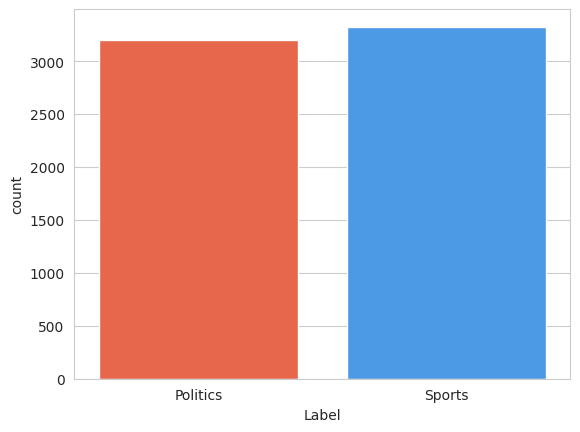

In [212]:
sns.countplot(x="Label",data =train, palette=["#FF5733", "#3399FF", "#33FF7A"])

In [213]:
def count_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    return len(hashtags)

def count_urls(text):
    urls_http = re.findall(r'http\S+', text)
#     urls_https = re.findall(r'https\S+', text)
    urls =urls_http
    return len(urls)
def count_mentions(text):
    urls = re.findall(r'@\w+', text)
    return len(urls)

def count_retweet(text):
    text = text.lower()
    rt = text.count("rt")
    rt += text.count("retweet")

    return rt



df_train['NumHashtags'] = df_train['TweetText'].apply(count_hashtags)
df_train['NumURLs'] = df_train['TweetText'].apply(count_urls)
df_train['NumMentions'] = df_train['TweetText'].apply(count_mentions)
df_train['NumRetweets'] = df_train['TweetText'].apply(count_retweet)

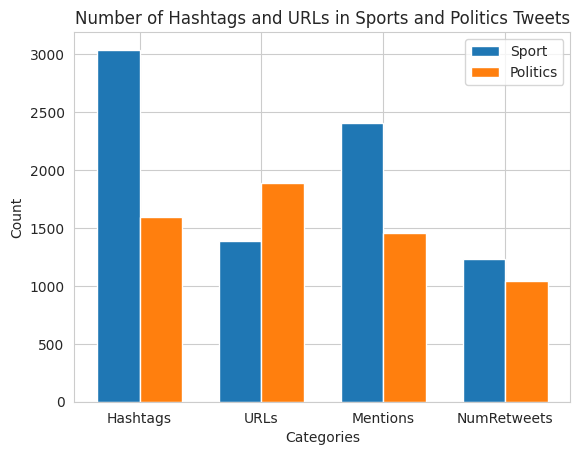

In [214]:
sport_tweets = df_train[df_train['Label'] == 'Sports']
politic_tweets = df_train[df_train['Label'] == 'Politics']
labels = ['Hashtags', 'URLs','Mentions','NumRetweets']
sport_data = [sport_tweets['NumHashtags'].sum(), sport_tweets['NumURLs'].sum(), sport_tweets['NumMentions'].sum(), sport_tweets['NumRetweets'].sum()]
politic_data = [politic_tweets['NumHashtags'].sum(), politic_tweets['NumURLs'].sum(),politic_tweets['NumMentions'].sum(),politic_tweets['NumRetweets'].sum()]

x = range(len(labels))

fig, ax = plt.subplots()
bar_width = 0.35
bars1 = ax.bar(x, sport_data, bar_width, label='Sport')
bars2 = ax.bar([p + bar_width for p in x], politic_data, bar_width, label='Politics')

ax.set_xlabel('Categories')
ax.set_ylabel('Count')
ax.set_title('Number of Hashtags and URLs in Sports and Politics Tweets')
ax.set_xticks([p + 0.5 * bar_width for p in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# <center> Data cleaning</center>

In [215]:
def clean_column(train):
    train['TweetText'] = train['TweetText'].str.replace('.', '')
    train['TweetText'] = train['TweetText'].str.replace('!', '')
    train['TweetText'] = train['TweetText'].str.replace('?', '')
    train['TweetText'] = train['TweetText'].str.replace('(', '')
    train['TweetText'] = train['TweetText'].str.replace(')', '')
    train['TweetText'] = train['TweetText'].str.replace('-', '')
clean_column(train)
clean_column(df_train)
clean_column(test)

In [216]:
def clean_Text(text):
    text=re.sub('@[A-Za-z0–9]+','',text) #Removing @mentions
    text=re.sub('#', '', text) # Removing '#' hash tag
    text=re.sub('RT[\s]+', '', text) # Removing RT
    text=re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    text=re.sub(':', '', text)
    text=re.sub("'", '', text)
    text=re.sub(",", '', text)
    text=re.sub(";", '', text)
    text=re.sub("&", '', text)
    text=re.sub("``", '', text)
    text=re.sub('"', '', text)
    return text
train['TweetText']=train['TweetText'].apply(clean_Text)
df_train['TweetText']=df_train['TweetText'].apply(clean_Text)
test['TweetText']=test['TweetText'].apply(clean_Text)

In [217]:
train.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,SecKerry The value of the and is measured no...
1,304834304222064640,Politics,1481 I fear so
2,303568995880144898,Sports,Watch video highlights of the wwc13 final betw...
3,304366580664528896,Sports,At Nitro Circus at AlbertPark theymakeitlook...
4,296770931098009601,Sports,Always a good thing Thanks for the feedback


In [218]:
def tolist(x):
    return x.split(' ')
train['TweetText']=train['TweetText'].apply(tolist)
train['TweetText'].astype(str)
df_train['TweetText']=df_train['TweetText'].apply(tolist)
df_train['TweetText'].astype(str)
test['TweetText']=test['TweetText'].apply(tolist)
test['TweetText'].astype(str)

0       ['28', 'The', 'home', 'side', 'threaten', 'aga...
1       ['', '', 'Thx', 'for', 'asking', 'See', '', 'I...
2       ['2014', 'construction', 'along', 'the', 'shor...
3       ['SecKerry\\u2019s', 'remarks', 'after', 'meet...
4       ['The', 'IPLauction', 'has', 'begun', 'Ricky',...
                              ...                        
2605    ['Qualifier', '1', 'and', 'Eliminator', 'games...
2606    ['', 'Hi', 'Edward', 'its', 'not', 'a', 'peace...
2607    ['Perera', 'was', '', 'first', 'IPL', 'purchas...
2608    ['SecKerry', 'Thanks', 'to', 'Senator', '', ''...
2609    ['Heres', 'a', 'picture', 'from', 'our', 'offi...
Name: TweetText, Length: 2610, dtype: object

In [219]:
#remove null strings
def remove_empty(x):
    return [item for item in x if item != '']
train['TweetText']=train['TweetText'].apply(remove_empty)
df_train['TweetText']=df_train['TweetText'].apply(remove_empty)
test['TweetText']=test['TweetText'].apply(remove_empty)

In [ ]:
def lower_case(data):
    for i in range(data.shape[0]) :
        data['TweetText'][i] = [x.lower() for x in data['TweetText'][i]]
    return data
lower_case(train)
lower_case(df_train)
lower_case(test)

In [166]:
train.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,"[seckerry, the, value, of, the, and, is, measu..."
1,304834304222064640,Politics,"[1481, i, fear, so]"
2,303568995880144898,Sports,"[watch, video, highlights, of, the, wwc13, fin..."
3,304366580664528896,Sports,"[at, nitro, circus, at, albertpark, theymakeit..."
4,296770931098009601,Sports,"[always, a, good, thing, thanks, for, the, fee..."


# <center> Exploratory Data Analysis after data cleaning</center>

In [221]:
from nltk.corpus import stopwords
nltk.download('stopwords')


stop_words = ['amp','the','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
def remove_stopwords(data):
    for i in range(data.shape[0]) :
        for word in  stop_words:
            if word in data['TweetText'][i]:
                data['TweetText'][i].remove(word)
    return data
df_train = remove_stopwords(df_train)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [222]:
from collections import Counter
def word_count(data):
    freqs = {}
    for i in range(data.shape[0]) :
        label = data['Label'][i]
        for word in  data['TweetText'][i]:
            pair = ((word,label))
            if pair in freqs :
                freqs[pair] += 1
            else :
                freqs[pair] = 1
    return freqs

In [223]:
df=pd.DataFrame.from_dict(word_count(df_train), orient='index', columns=['count'])
#create the two columns word , label
df.reset_index(inplace=True)
df[['word','label']] = pd.DataFrame(df['index'].tolist(), index=df.index)
df.drop(columns=['index'], inplace=True)

In [224]:
#sort by count
df.sort_values(by=['count'], ascending=False, inplace=True)

In [225]:
#reindex
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df.head()

,count,word,label
0,347,indvaus,Sports
1,329,president,Politics
2,314,test,Sports
3,253,to,Politics
4,236,obama,Politics


In [226]:
#create the weight for a word in the whole of the dataset grouped by label
df['weights']=df['count']/df.groupby('label')['count'].transform('sum')
df.head()

,count,word,label,weights
0,347,indvaus,Sports,0.010096
1,329,president,Politics,0.009919
2,314,test,Sports,0.009136
3,253,to,Politics,0.007628
4,236,obama,Politics,0.007115


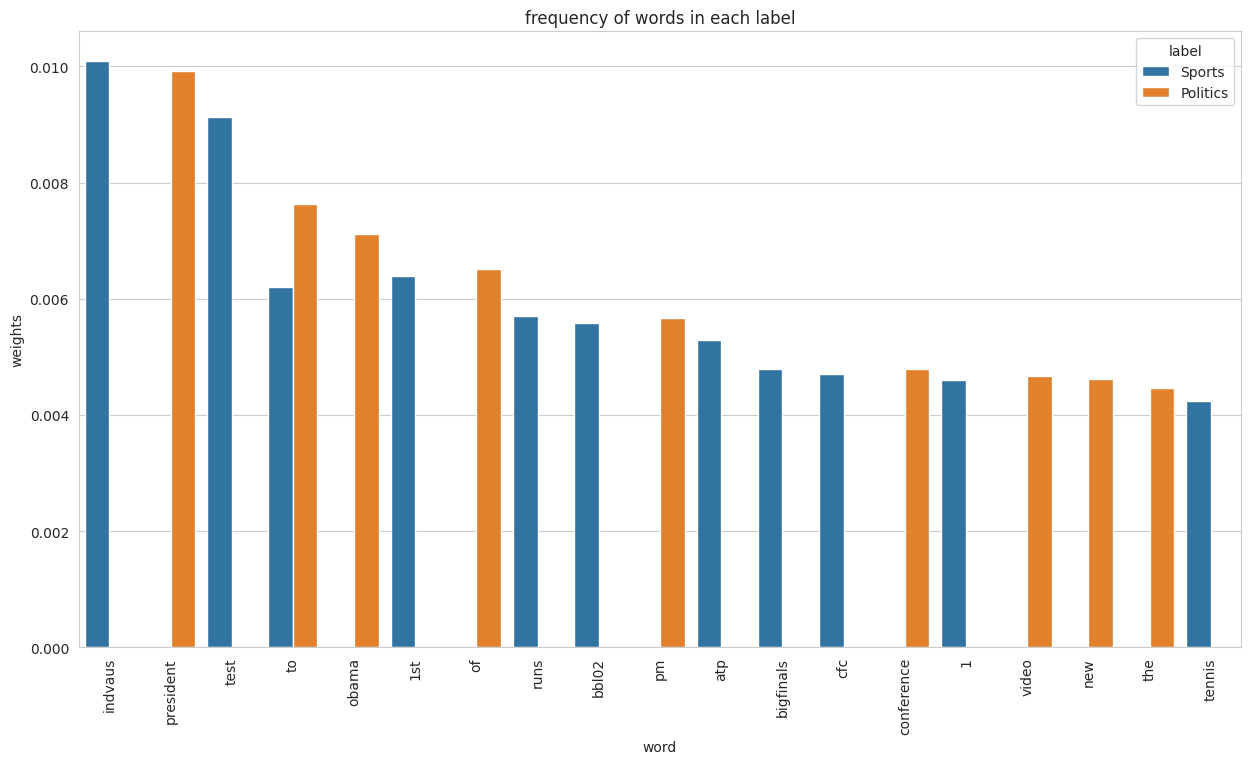

In [227]:
#plot of weith of each word
sns.set_style('whitegrid')
plt.figure(figsize=(15, 8))
sns.barplot(x='word', y='weights', hue='label', data=df.head(20)).set(title='frequency of words in each label')
plt.xticks(rotation=90)
plt.show()

# <center> Feature extraction</center>

In [228]:
# Convert list elements to strings and then apply TF-IDF vectorizer
tfidfconverter = TfidfVectorizer()
X = tfidfconverter.fit_transform(train['TweetText'].apply(' '.join))
y = train['Label']

In [229]:
testtfid = tfidfconverter.transform(test['TweetText'].apply(' '.join))

# <center> Model training, evaluation and selection</center>

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# <center> Logistic regression</center>

In [231]:

# Initialize the classifier
classifier = LogisticRegression()

# Train the classifier
classifier.fit(X_train, y_train)

LogisticRegression()

In [232]:
from sklearn.metrics import accuracy_score
y_pred = classifier.predict(X_test)
# Calculate training accuracy
training_accuracy = accuracy_score(y_test, y_pred)
print(training_accuracy)

0.9187739463601533


# <center> Random forest classifier</center>

In [233]:
param_grid = {'n_estimators': [100,200,500],
              'criterion': ['gini', 'entropy', 'log_loss']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

grid.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [100, 200, 500]})

In [234]:
print(grid.best_score_)
print(grid.best_params_)

0.9046743295019157
{'criterion': 'log_loss', 'n_estimators': 500}


# <center> Support vector machine</center>

In [45]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf',  'poly', 'sigmoid']
}

# Instantiate SVM classifier
svm = SVC()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)

# Fit the model
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'poly', 'sigmoid']})

In [47]:
modelsvm = grid_search.best_estimator_

# <center> Multinomial naive-bayes</center>

In [235]:
modelNB = MultinomialNB(alpha=2)
modelNB.fit(X_train, y_train)

MultinomialNB(alpha=2)

In [236]:
y_pred = modelNB.predict(X_test)
# Calculate training accuracy
training_accuracy = accuracy_score(y_test, y_pred)
print(training_accuracy)

0.9417624521072797


In [240]:
param_grid = {'alpha': [1,2,3,4,5]}

grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)

grid.fit(X, y)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [1, 2, 3, 4, 5]})

In [241]:
grid.best_estimator_

MultinomialNB(alpha=1)

In [242]:
modelNB = MultinomialNB(alpha=1)
modelNB.fit(X, y)

MultinomialNB(alpha=1)

# <center> Submission</center>

In [243]:
Label=modelNB.predict(testtfid)
TweetId=test['TweetId']
sample_submission = pd.DataFrame({'TweetId': TweetId, 'Label': Label})

In [244]:
sample_submission.to_csv('sample_submission.csv', index=False)